#### 네이버 뉴스 검색 API

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os
import nltk
from time import time
from scipy.io.arff import loadarff
from scipy import stats
from statsmodels.formula.api import ols, glm
from functools import reduce     
import re
import sys
import urllib.request

from nltk.tokenize import word_tokenize   
from nltk.corpus import stopwords         
from nltk.stem import WordNetLemmatizer    
from collections import Counter 
from wordcloud import STOPWORDS, WordCloud
import glob           
import konlpy
import json

from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

import matplotlib
import matplotlib.font_manager as fm

import matplotlib
import matplotlib.font_manager as fm
font_loc = 'C:/Windows/Fonts/H2PORM.TTF'
font_name = fm.FontProperties(fname=font_loc).get_name()
matplotlib.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# from matplotlib import rc
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 네이버 기사 검색 API를 DataFrame으로 변환하는 함수
def api_article_search(search):
    client_id = "2oMII3aNFw4Ixrv4yTLR"
    client_secret = "RxaobQ9vnZ"

    query = urllib.parse.quote(search)
    idx = 0
    display = 100 
    start = 1
    end = 1000
    sort = 'date'

    news_df = pd.DataFrame(columns=("Title", "Original Link", "Link", "Description", "Publication Date"))

    for start_index in range(start, end, display):

        url = "https://openapi.naver.com/v1/search/news?query=" + query \
              + "&display=" + str(display) \
              + "&start=" + str(start_index) \
              + "&sort=" + sort

        request = urllib.request.Request(url)
        request.add_header("X-Naver-Client-Id",client_id)
        request.add_header("X-Naver-Client-Secret",client_secret)
        response = urllib.request.urlopen(request)
        rescode = response.getcode()
        if(rescode==200):
            response_body = response.read()
            response_dict = json.loads(response_body.decode('utf-8'))
            items = response_dict['items']
            for item_index in range(0, len(items)):
                remove_tag = re.compile('<.*?>')
                title = re.sub(remove_tag, '', items[item_index]['title'])
                original_link = items[item_index]['originallink']
                link = items[item_index]['link']
                description = re.sub(remove_tag, '', items[item_index]['description'])
                pub_date = items[item_index]['pubDate']
                news_df.loc[idx] = [title, original_link, link, description, pub_date]
                idx += 1
        else:
            print("Error Code:" + rescode)

    return news_df

In [3]:
news_dfs = api_article_search('레이 달리오 예측')
news_df1 = news_dfs[news_dfs['Publication Date'].str.contains('2022', 'Aug')]
news_df2 = news_dfs[news_dfs['Publication Date'].str.contains('2022', 'Jul')]
news_df = pd.concat([news_df1, news_df2])

In [4]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 0 to 95
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Title             192 non-null    object
 1   Original Link     192 non-null    object
 2   Link              192 non-null    object
 3   Description       192 non-null    object
 4   Publication Date  192 non-null    object
dtypes: object(5)
memory usage: 9.0+ KB


In [5]:
# 기사 제목 변수에 입력
df1_title = news_df['Title']

In [6]:
# 특수문자 제거하기

In [7]:
compile = re.compile("[^ ㄱ-ㅣ가-힣]+")
list_title=[]
for i in range(len(df1_title.values)):
    a = compile.sub("",df1_title.values[i])
    list_title.append(a)

In [9]:
# 문장분석
okt = Okt()
result =[]
result = [okt.nouns(i) for i in list_title] #명사만 추출
final_result= [r for i in result for r in i]

In [10]:
# 텍스트에서 많이 나온 단어
temp =[w for w in final_result if len(w) > 1]
temp_count = Counter(temp)
temp_count = dict(temp_count.most_common(100))
temp_count.keys()

dict_keys(['투자', '경제', '세계', '하락', '레이', '인플레', '헤지펀드', '금리', '예측', '증시', '최대', '금융', '자산', '사이클', '긴축', '글로벌', '뉴스', '주식', '전문가', '신간', '침체', '미래', '거물', '비트코인', '현금', '쓰레기', '전략', '시대', '이슈', '추가', '경고', '위기', '변화', '수익', '달러', '채권', '주목', '빅사', '시작', '오전', '주요', '국제', '확률', '뉴욕증시', '경험', '경기', '역사', '마켓', '퀀트', '황현희', '촉구', '멀리', '시장', '돈나무', '언니', '주가', '인플레이션', '도서', '다시', '식이', '지금', '보고서', '포럼', '리기', '기술', '부동산', '충격', '종목', '미국', '폭락', '칼럼', '질서', '부자', '최악', '작별인사', '탈환', '파산', '인생', '가장', '배당', '통화', '전쟁', '고음', '기고', '메타', '나스닥', '자산운용', '대신', '가능성', '버블', '도구', '급감', '랠리', '피봇', '기대', '단절', '김영', '주장', '성공예감', '겨울왕국'])

In [11]:
# 불용어 제거하기
remove_list = ['레이', '헤지펀드', '최대', '사이클', '뉴스', '신간', '거물', '추가', '빅사', '오전', '주요']

In [12]:
# 워드 클라우드 정의 함수
def showTextCloud(listValue:list, remove_list:list, count = 0):
    temp =[w for w in final_result if len(w) > 1]
    temp = [w for w in temp if not np.any([w[-10:] in remove_list, w[-1] in remove_list])]
    temp_count = Counter(temp)
    if count != 0:     
        temp_count = dict(temp_count.most_common(count)) # 상위 count개
    wc = WordCloud(font_loc ,background_color='white',width=800,height=600)
    cloud = wc.generate_from_frequencies(temp_count)
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

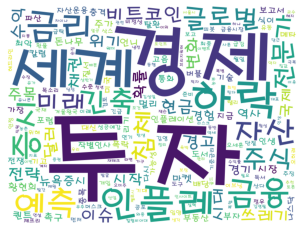

In [13]:
# 워드 클라우드 출력
showTextCloud(final_result, remove_list)

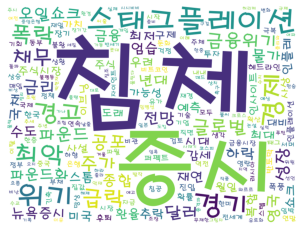

In [14]:
news_df1 = api_article_search('누리엘 루비니 예측')
news_df1 = news_df1[news_df1['Publication Date'].str.contains('2022', 'Aug')]
news_df2 = news_df1[news_df1['Publication Date'].str.contains('2022', 'Jul')]
news_df = pd.concat([news_df1, news_df2])
news_df = pd.concat([news_df1, news_df2])

df1_title = news_df['Title']

compile = re.compile("[^ ㄱ-ㅣ가-힣]+")
list_title=[]
for i in range(len(df1_title.values)):
    a = compile.sub("",df1_title.values[i])
    list_title.append(a)

remove_list = ['닥터', '루비', '세계', '내년', '교수', '착륙', '칼럼', '역대', '뉴스', '상반기', '추가']

okt = Okt()
result =[]
result = [okt.nouns(i) for i in list_title] #명사만 추출
final_result= [r for i in result for r in i]

showTextCloud(final_result, remove_list)


In [15]:
temp =[w for w in final_result if len(w) > 1]
temp_count = Counter(temp)
temp_count = dict(temp_count.most_common(100))
temp_count.keys()

dict_keys(['침체', '닥터', '루비', '증시', '스태그플레이션', '위기', '경기', '경제', '최악', '경고', '폭락', '급락', '세계', '채무', '글로벌', '금융위기', '주가', '공포', '추가', '성장', '파운드', '금리', '달러', '내년', '역대', '교수', '전망', '오일쇼크', '파운드화', '영국', '종합', '뉴스', '하락', '물가', '년대', '상반기', '뉴욕증시', '국채', '최저', '금융', '수도', '칼럼', '엄습', '재연', '환율', '쇼크', '감세', '최대', '추락', '미국', '시대', '복합', '스톰', '우려', '예측', '인플레', '주식시장', '인사이트', '사상', '가치', '구제', '가능성', '사설', '대비', '주식', '도래', '월일', '이브닝', '헤드라인', '한국', '인플레이션', '장기', '진입', '투자', '확률', '퍼펙트', '후퇴', '폭풍', '반토막', '침공', '둔화', '전세계', '비트코인', '국제', '유가', '영란', '은행', '매입', '중국', '시작', '정책', '검토', '불황', '금융시장', '상황', '확산', '주체', '모두', '기업', '정부'])